In [1]:
%matplotlib inline

#system
import os
import glob

#math
import numpy as np

#video and image
import cv2
import moviepy
from moviepy.editor import VideoFileClip

#display
import matplotlib.pyplot as plt
import matplotlib.image as mplimg


# Camera Calibration

In [2]:
# taken from code in examples folder

#chessboard dimensions
nx, ny = (9, 6)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

#         # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)
# cv2.destroyAllWindows()

# get camera calibration constants
iscalibrated, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### Test extracted camera calibration coefficients on undistorting images

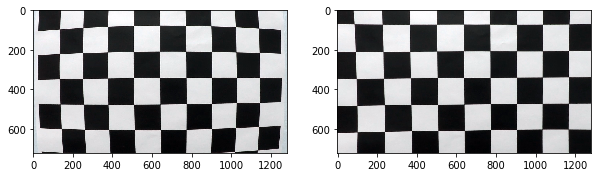

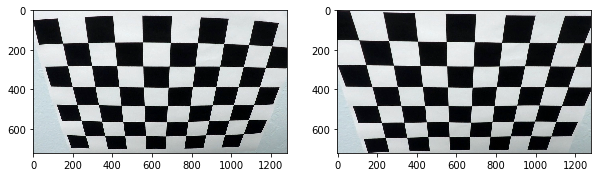

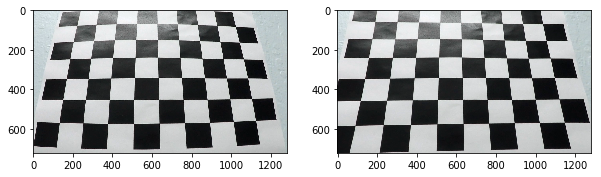

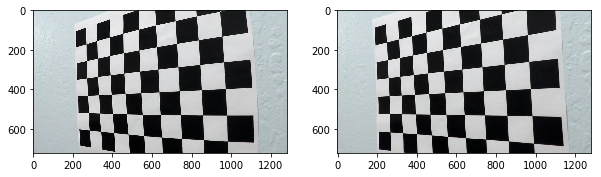

In [15]:
#test camera calibration
for i in range(1,5):
    calibration_img = cv2.imread('camera_cal/calibration{}.jpg'.format(i))
    undistorted_img = cv2.undistort(calibration_img, mtx, dist, None, mtx)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
    ax1.imshow(calibration_img)
    ax2.imshow(undistorted_img)

# Convert to binary image 

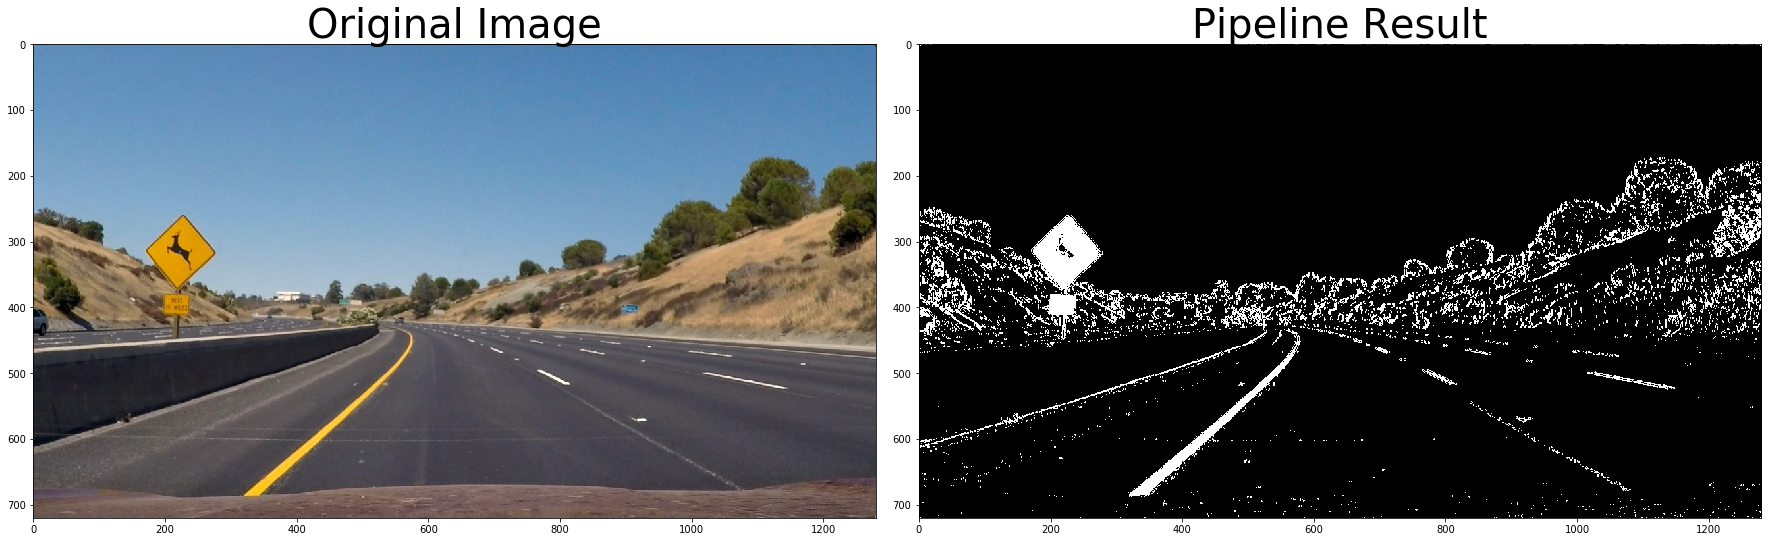

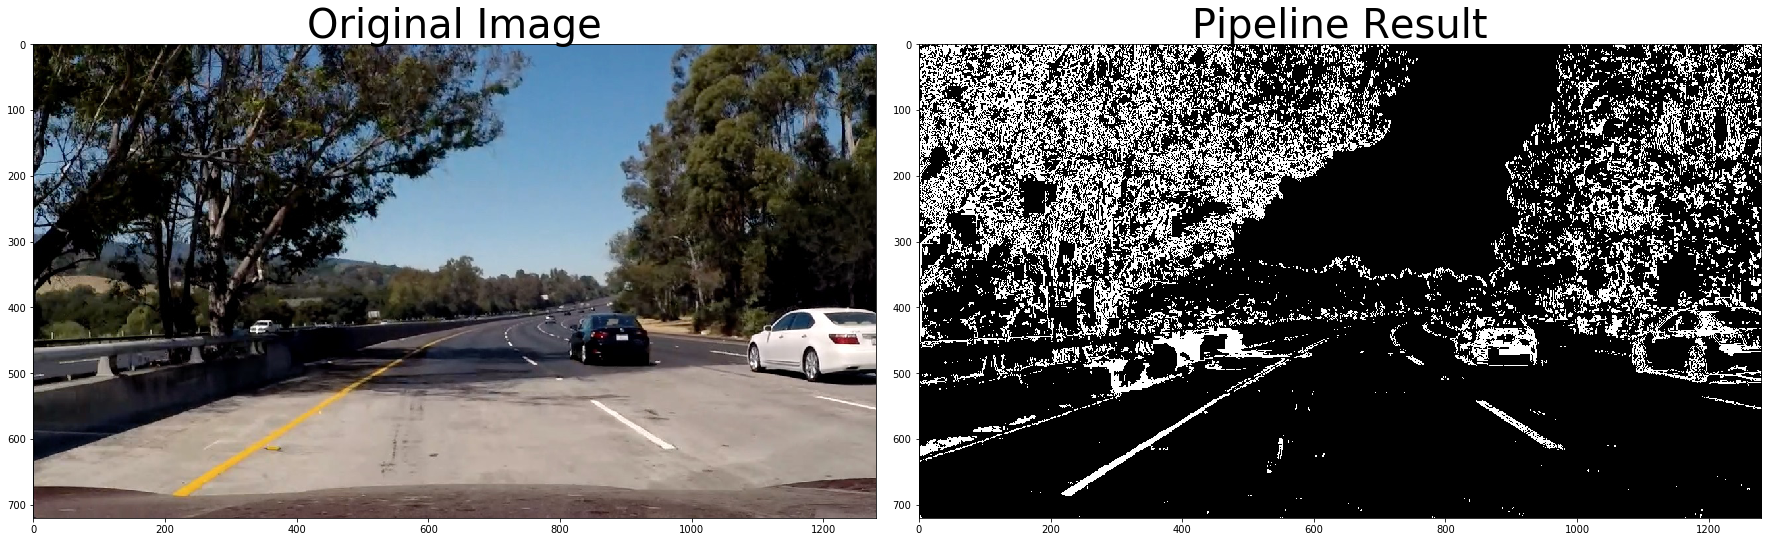

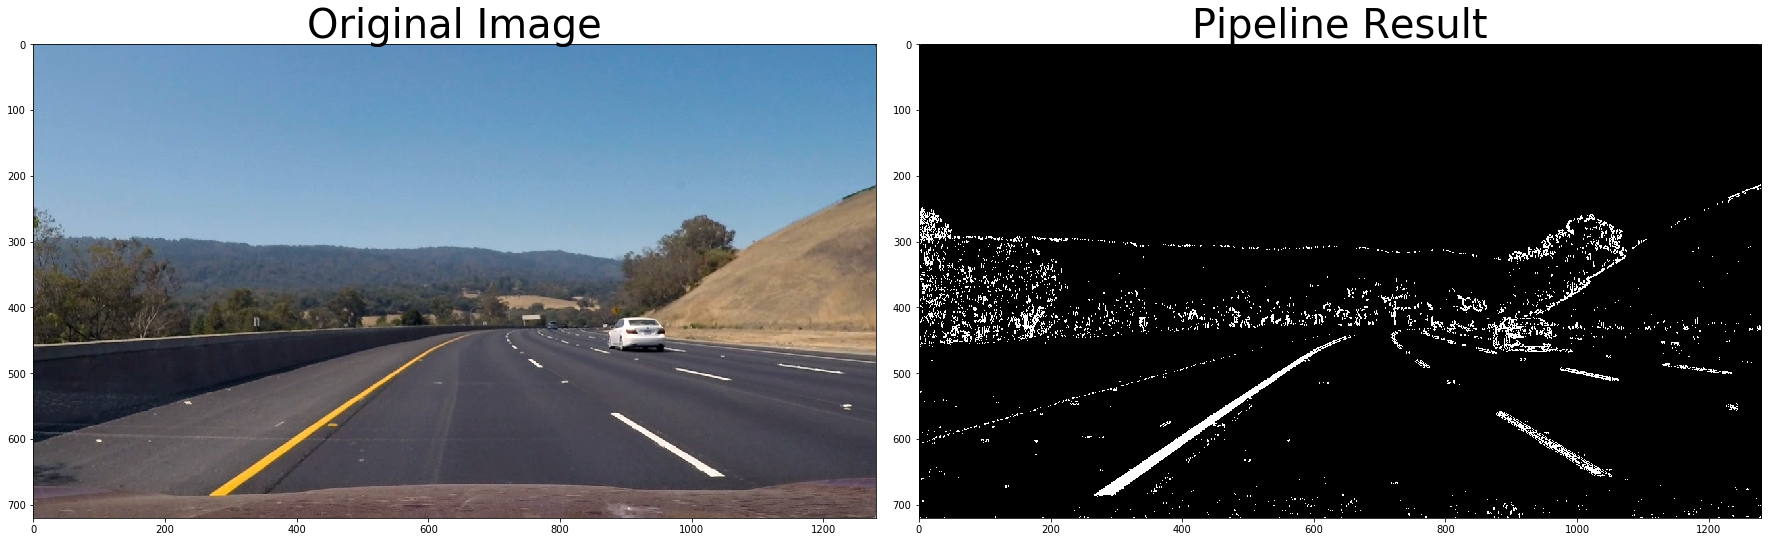

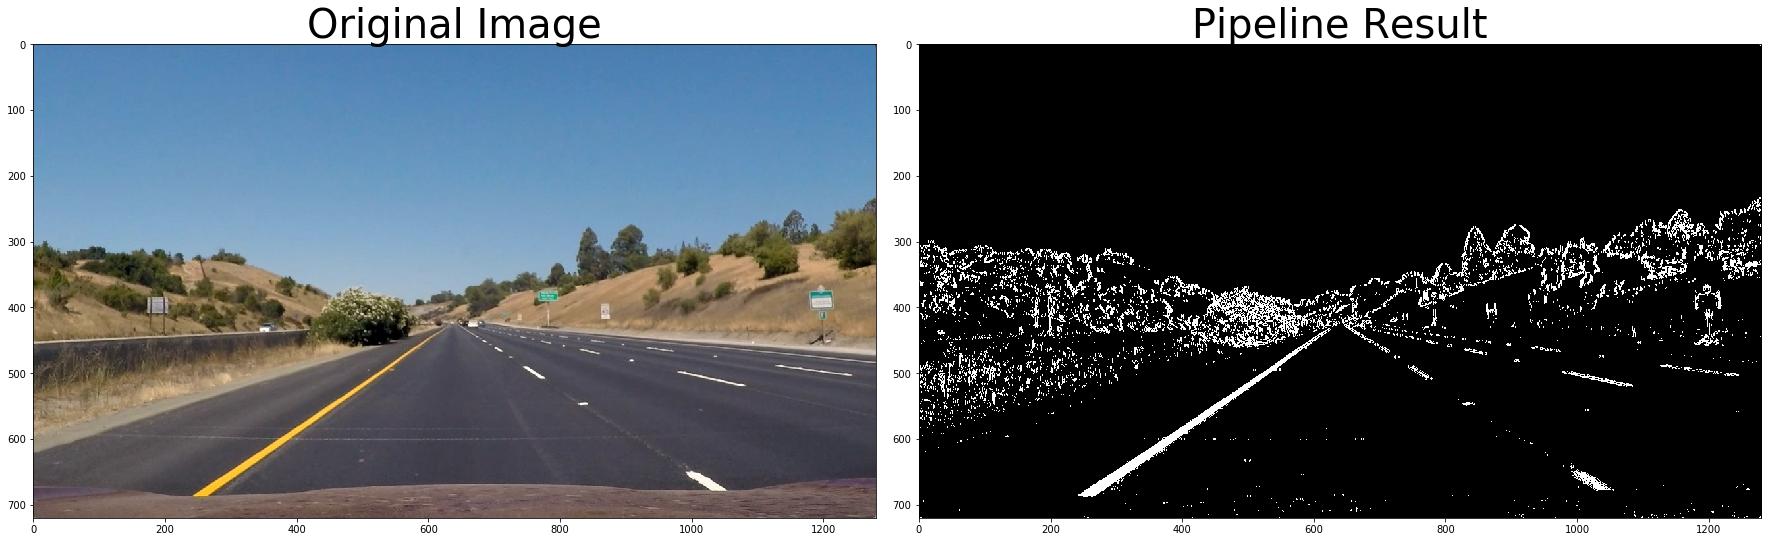

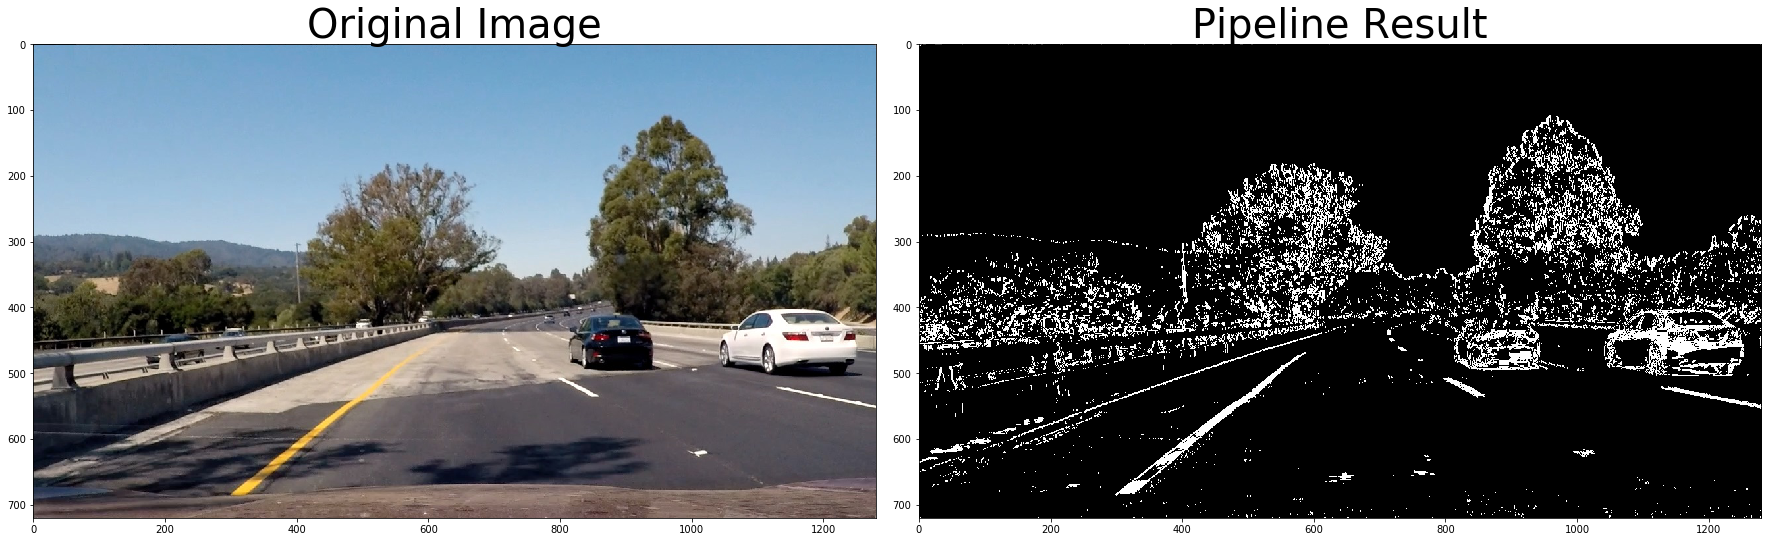

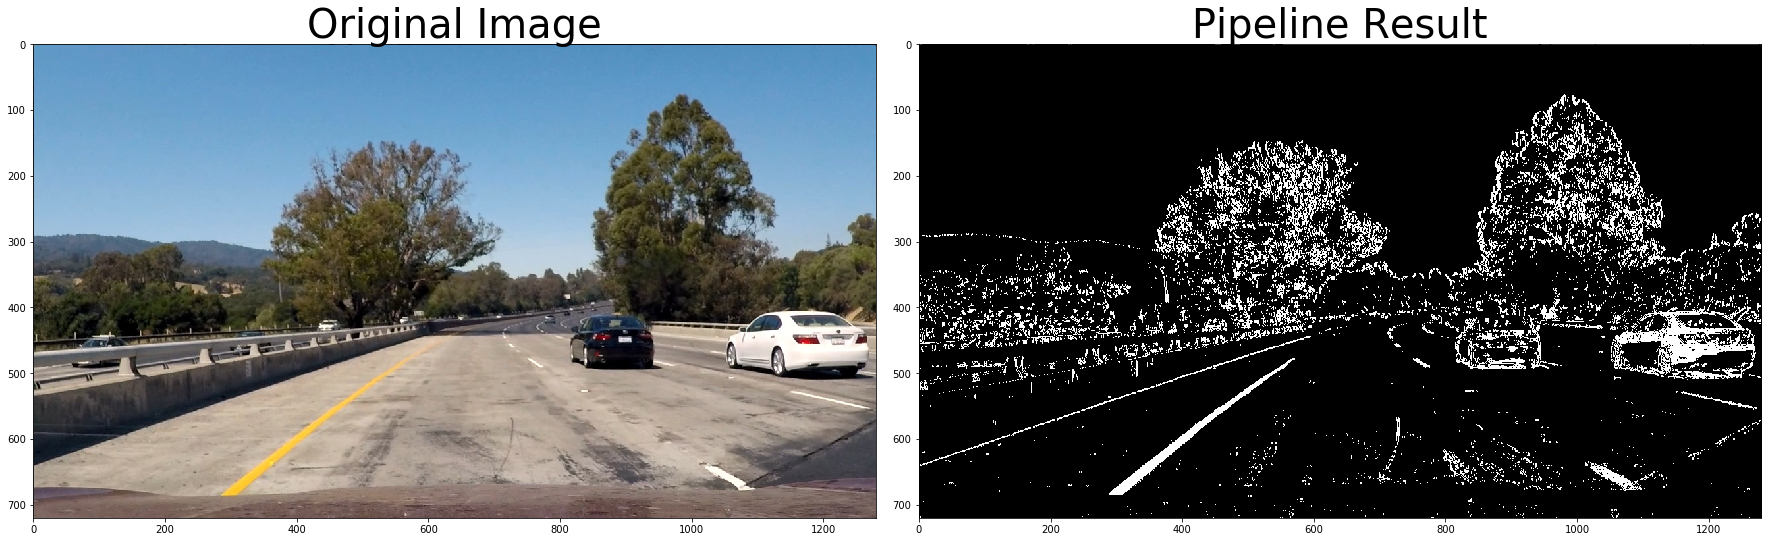

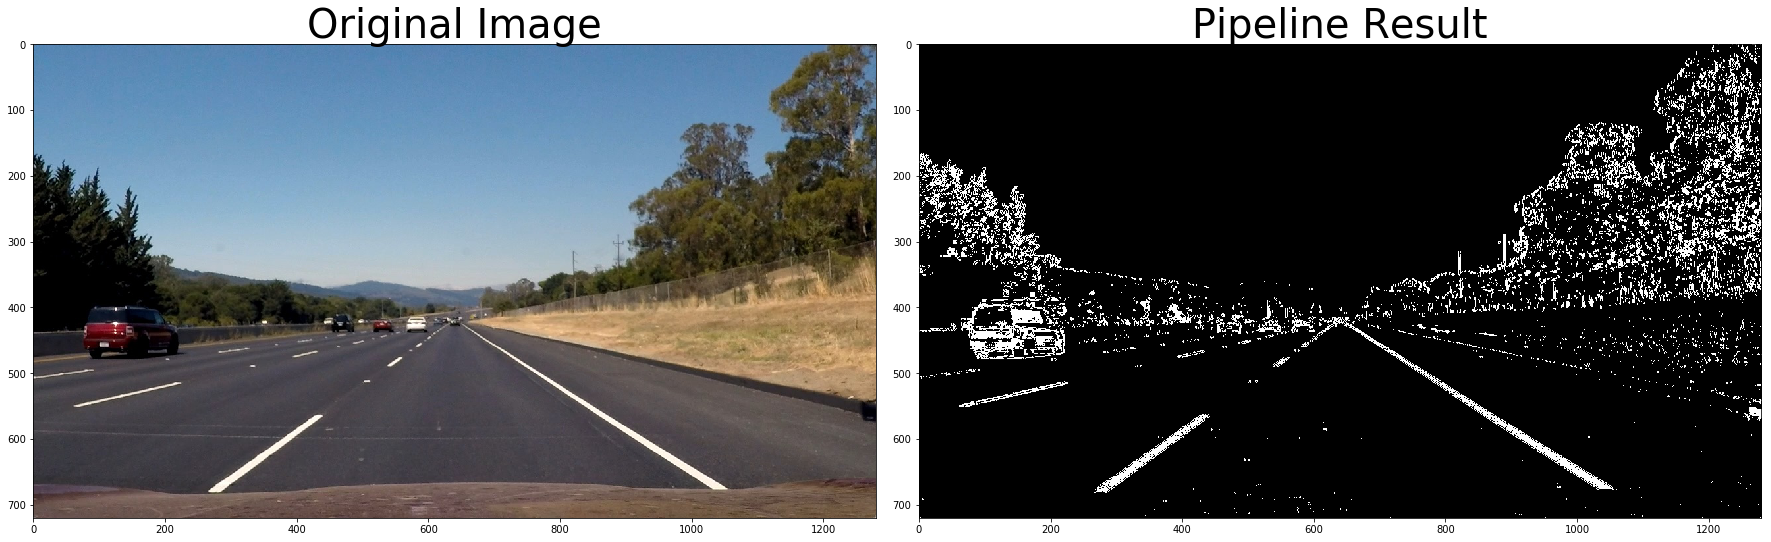

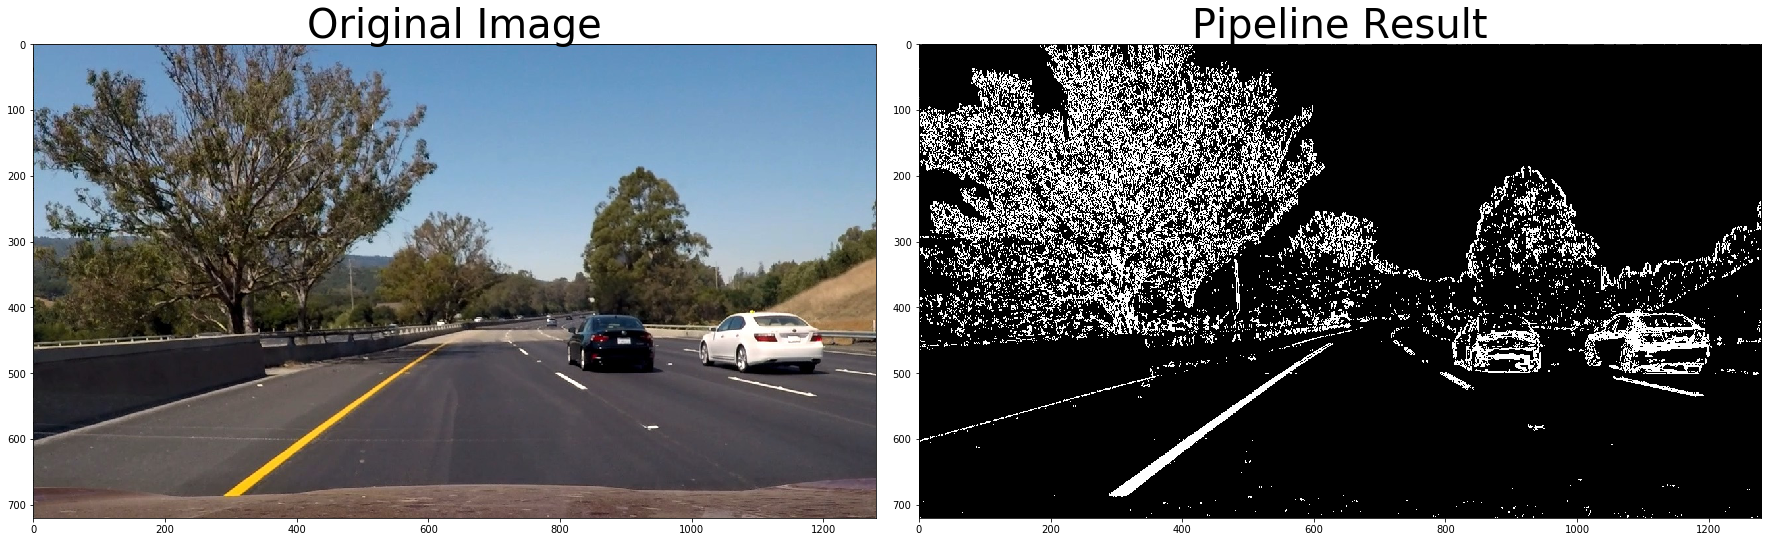

In [22]:
# Edit this function to create your own pipeline.
def convert_to_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1
    
    return combined_binary

for f in os.listdir('test_images/'):
    image = mplimg.imread('test_images/' + f)
    result = pipeline(image)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Processing pipeline

1. Correct for distortion
2. Transform RGB to binary image
3. Perform perspective transform to create "top view"
4. Polynomial fit on left and right lanes
5. Get R-curvature
